Titanic Challenge 
Great Resource: https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy

In [14]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
import seaborn as sns

Let's load the data and make a copy of both training and test set to do the Data Cleaning process. 

In [15]:
train_raw = pd.read_csv('train.csv')
test_raw = pd.read_csv('test.csv')

train_data = train_raw.copy(deep=True)
test_data = test_raw.copy(deep=True)
print(train_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


Now check how many missing values exist in each column

In [16]:
train_raw.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [17]:
test_raw.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Now we create and array to iterate over training and test set, so that we dont have to write 2 lines of code per operation. We will fill NaN values, create and modify features. 

In [18]:
dataset_array =[train_data, test_data]
for dataset in dataset_array:
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace=True)
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace=True)
    # extract title from name and create new feature named title
    dataset['Title'] = dataset['Name'].str.split(',', expand=True)[1].str.split('.', expand=True)[0]
    
print(train_data.Title.unique())


[' Mr' ' Mrs' ' Miss' ' Master' ' Don' ' Rev' ' Dr' ' Mme' ' Ms' ' Major'
 ' Lady' ' Sir' ' Mlle' ' Col' ' Capt' ' the Countess' ' Jonkheer']


We now have a title feature that can give a bit more insight than the original name column. We also filled the fare column with the median and the embarked feature with the most common case.
Now we are going to fill the age feature and filter out the titles that are not that frequent. For the age column we will fill with the median according to the title of the person, because it does not make much sense having a kid (Master) having an age of 35.

In [19]:
# get a boolean series where true = relevant title, false = irrelevant title
title_bool = (train_data['Title'].value_counts() >= 10)
for dataset in dataset_array:
    dataset['Title'] = dataset['Title'].apply(lambda x: x if (x in title_bool.index and title_bool.loc[x] == True)else 'Misc')
    # the can be titles not present on the training set therefore we need the first check to be that
mean_per_title = train_data.groupby('Title')['Age'].mean()
for dataset in dataset_array:
    dataset['Age'] = dataset['Title'].apply(lambda x: mean_per_title.loc[x])

Let's see the results!

In [20]:
train_data.sample(7)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
54,55,0,1,"Ostby, Mr. Engelhart Cornelius",male,32.368090,0,1,113509,61.9792,B30,C,Mr
59,60,0,3,"Goodwin, Master. William Frederick",male,4.574167,5,2,CA 2144,46.9000,NaN,S,Master
397,398,0,2,"McKane, Mr. Peter David",male,32.368090,0,0,28403,26.0000,NaN,S,Mr
854,855,0,2,"Carter, Mrs. Ernest Courtenay (Lilian Hughes)",female,35.898148,1,0,244252,26.0000,NaN,S,Mrs
534,535,0,3,"Cacic, Miss. Marija",female,21.773973,0,0,315084,8.6625,NaN,S,Miss
157,158,0,3,"Corn, Mr. Harry",male,32.368090,0,0,SOTON/OQ 392090,8.0500,NaN,S,Mr
211,212,1,2,"Cameron, Miss. Clear Annie",female,21.773973,0,0,F.C.C. 13528,21.0000,NaN,S,Miss


Now we will make fare and age 4 and 5 categories respectively, using the qcut and cut method from pandas. And we will create 2 new features, the family size feature (sibsp + parch) and the isAlone feature.

In [21]:
for dataset in dataset_array:
    # create family size feature
    dataset['Family Size'] = dataset['SibSp'] + dataset['Parch'] + 1
    # set 0 to those samples that have family size greater than 1
    dataset['isAlone'] = np.where(dataset['Family Size'] > 1, 0, 1)
    # cut the fare feature into 4 bins
    dataset['Fare'] = pd.qcut(dataset['Fare'], 4)
    # cut the age feature into 5 bins, we use cut because age has a more even distribution
    dataset['Age'] = pd.cut(dataset['Age'], 5)

Now we delete the features that we dont need anymore and thos that do not give much insight.

In [22]:
feature_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']
for dataset in dataset_array:
    dataset.drop(feature_drop, axis=1, inplace=True)
train_data.sample(7)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Family Size,isAlone
359,1,3,female,"(19.698, 27.26]",0,0,"(-0.001, 7.91]",Q,Miss,1,1
671,0,1,male,"(27.26, 34.823]",1,0,"(31.0, 512.329]",S,Mr,2,0
468,0,3,male,"(27.26, 34.823]",0,0,"(-0.001, 7.91]",Q,Mr,1,1
330,1,3,female,"(19.698, 27.26]",2,0,"(14.454, 31.0]",Q,Miss,3,0
587,1,1,male,"(27.26, 34.823]",1,1,"(31.0, 512.329]",C,Mr,3,0
266,0,3,male,"(27.26, 34.823]",4,1,"(31.0, 512.329]",S,Mr,6,0
867,0,1,male,"(27.26, 34.823]",0,0,"(31.0, 512.329]",S,Mr,1,1


In [23]:
encoder = LabelEncoder()
for dataset in dataset_array:
    dataset['Age'] = encoder.fit_transform(dataset['Age'])
    dataset['Fare'] = encoder.fit_transform(dataset['Fare'])
    '''dataset['Sex'] = encoder.fit_transform(dataset['Sex'])
    dataset['Embarked'] = encoder.fit_transform(dataset['Embarked'])
    dataset['Title'] = encoder.fit_transform(dataset['Title'])
    title_orignals = encoder.transform(np.array(dataset['Title'].unique()))'''


Before encoding and preparing the data to be used by a learning algorithm let's visualize the data to gain more insight.

Text(0,0.5,'Number of People')

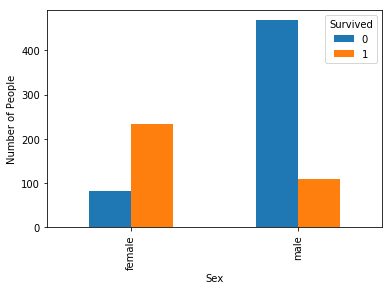

In [24]:
train_data.groupby(['Sex', 'Survived']).size().unstack().plot(kind='bar')
plt.ylabel('Number of People')

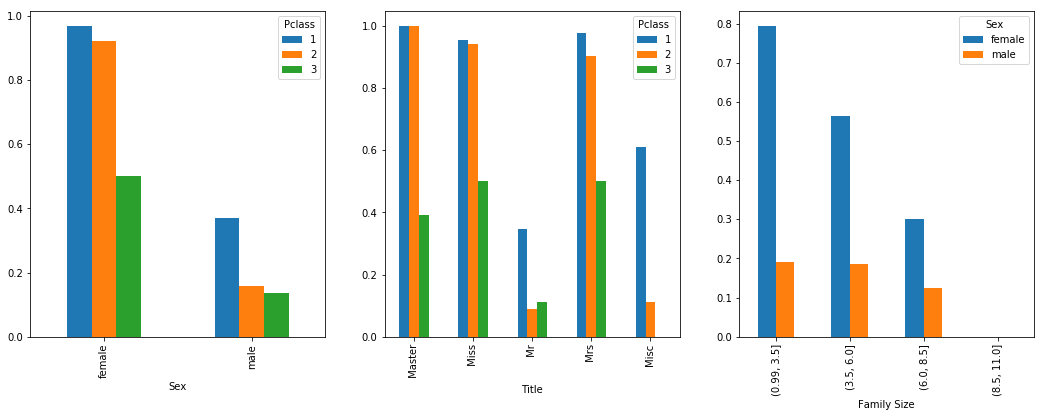

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=[18,6])
train_data.pivot_table('Survived', index='Sex', columns='Pclass').plot(kind='bar', ax=axes[0])
train_data.pivot_table('Survived', index='Title', columns='Pclass').plot(kind='bar', ax=axes[1])
train_data.pivot_table('Survived', index=pd.cut(train_data['Family Size'], 4), columns='Sex').plot(kind='bar', ax=axes[2])